# Segmentation map으로 도로 이미지 만들기

## 데이터 준비하기

In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

다양한 방법이 있었지만, 공식 튜토리얼에서 나온 방식을 사용했다.
나는 개인적으로 쉘스크립트를 선호하고 자주 사용했지만, 텐서플로우의 이러한 기능은 너무 편리했다.

In [2]:
dataset_name = 'cityscapes'

_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

/가 수식 기호인데 여기서 이렇게 쓰이는 것을 보고 당황스럽겠지만

\_\_truediv__ 를 재정의 한것 뿐이다.

https://www.programiz.com/python-programming/operator-overloading

In [3]:
# 위에서 정의한 PATH를 통해 파일들을 가져온다.
# 놀랍게도 샴쌍둥이다.
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


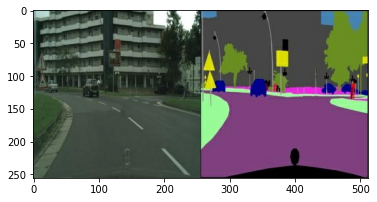

In [4]:
# 잘 나오는 것을 볼 수 있다.
plt.figure()
plt.imshow(sample_image)

In [5]:
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    # 위는 원본 주석인데, 이미지를 uint8 텐서로 읽어온다는 예기다.
    image = tf.io.read_file(image_file)
    # 여기가 디코드
    image = tf.io.decode_jpeg(image)

    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image 
    # 이미지와 라벨을 나눠준다고 한다.
    # 두 이미지를 반을 가른다고 보면 된다.
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    # Convert both images to float32 tensors
    # 각 이미지를 float32로 변환해주는 친구. 이름부터 cast
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

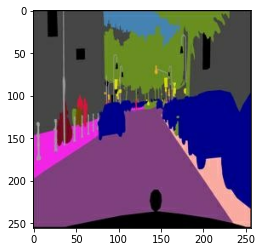

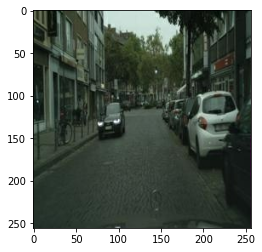

In [6]:
inp, re = load(str(PATH / 'train/100.jpg'))
# matplotlib를 위해 정수형으로 변형해서 보여줬데요.
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

## 데이터셋 구성 및 데이터 증강 Augmentation 구성

In [7]:
# The facade training set consist of 400 images
# 하지만 cityscapes는 1000개로 되어있다. 
# 따라서 Buffer size도 1000

BUFFER_SIZE = 1000
# 논문상에서 배치크기 1이 U-NET에게 있어서 더 나은 결과를 준다네요.
BATCH_SIZE = 1 # 그 아이디어 그대로 차용
# 각 이미지 사이즈
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [8]:
# 이미지 리사이즈 해주는 친구인데, cv도구가 tf에도 있어서 이걸 차용한 모습이네요.
# NEAREST_NEIGHBOR에 대해 간단히 말하자면. 가장 가까운 위치에 있는 픽셀을 참조하여
# 영상의 빈곳을 채우는 알고리즘이다.
# 참고: https://jackyoon5737.tistory.com/62

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [9]:
# 이미지를 크롭해주는 친구, 적당히 조각내서 노이즈를 유발한다.
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [10]:
# Normalizing the images to [-1, 1]
# 이미지를 정규화시켜준다.
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [11]:
# tf2는 Eager execution가 기본 실행인데, Eager execution에서 성능 이슈가 발생한다.
# 그래서 tf.function 데코레이터를 호출함
# 참고: https://www.tensorflow.org/guide/function?hl=ko

# 지터라는 것은 신호처리학 용어인데, 시간축상으로 흐트러지는 것이라고 하는데
# 뒤틀린다는 느낌으로 보면 될 것 같다.
# 참고: http://www.ktword.co.kr/test/view/view.php?m_temp1=991

# 이 함수는 위의 리사이즈와 크롭을 통해 이미지에 지터를 일으킨다.

@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    # 리사이즈
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    # 크롭
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        # a.k.a 좌우반전
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

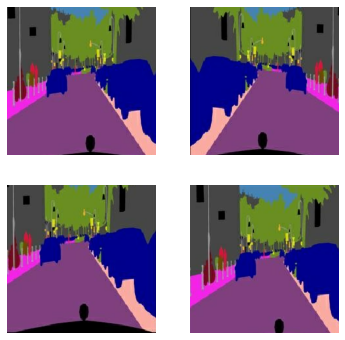

In [12]:
# 위 결과를 보여준다.
# 여기서는 input_image만 출력한다.

plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

In [13]:
# 학습을 위한 이미지 전처리이다.
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image) # 여기를주목하자
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [14]:
# 테스트를 위한 데이터 전처리이며, 지터가 없다.
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [15]:
# 해당 함수를 이용해서 데이터셋을 구성한다.
# map을 사용해서 일괄 처리를 수행했다.
# tfds의 장점이 보인다.
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [16]:
# 테스트셋도 동일하게 준비
try:
    test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## U-Net 구성

In [17]:
# RGB
OUTPUT_CHANNELS = 3

U-Net은 오토인코더와 마찬가지로 인코더-디코더 기반 모델에 속한다.
인코딩 단계에서는 채널수를 늘리면서 차원수를 축소해나가며,
디코딩 단계에서는 저차원으로 인코딩된 정보만을 이용해서 채널의 수를 줄이고 차원 수를 늘려 고차원의 이미지를 복원한다.

참고: https://pasus.tistory.com/204

아래 레이어에는 다음의 특징이 있다.
- 인코더의 각 블록은 다음과 같다: 컨볼루션 -> 배치 정규화 -> 누출이 있는 ReLU
- 디코더의 각 블록은 다음과 같다: 전치된 컨볼루션 -> 배치 정규화 -> 드롭아웃(처음 3개 블록에 적용됨) -> ReLU
- 인코더와 디코더 사이에는 건너뛰기 연결이 있다(U-Net에서와 같이).

In [18]:
# 다운 샘플러 표현
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        # Conv2D에 strides가 2인것도 중요한 주목거리다.
        # 논문에 그렇게 기제되어 있다고 언급이 있더라
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [19]:
# 레이어 실습
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [20]:
# 업셈플러 표현
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        # conv 과정을 되돌리기위해 transpose가 달린 친구를 쓴다.
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [21]:
# 동작 시연
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [22]:
# 생성 모델
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        # 잘 보면 다운 샘플러이지만 채널수가 증가한다.
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        # 여기는 점점 줄어드는 상황
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    # 랜던 정규분포로 초기화
    initializer = tf.random_normal_initializer(0., 0.02)
    # 마지막에 이미지 복원을 위해 사용, 활성화로 tanh를 씀
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    # 입력
    x = inputs

    # Downsampling through the model
    # 다운 셈플러 실행
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    # 업셈플러 실행
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    #마무리
    x = last(x)
    
    # 완성된 모델 반환
    return tf.keras.Model(inputs=inputs, outputs=x)

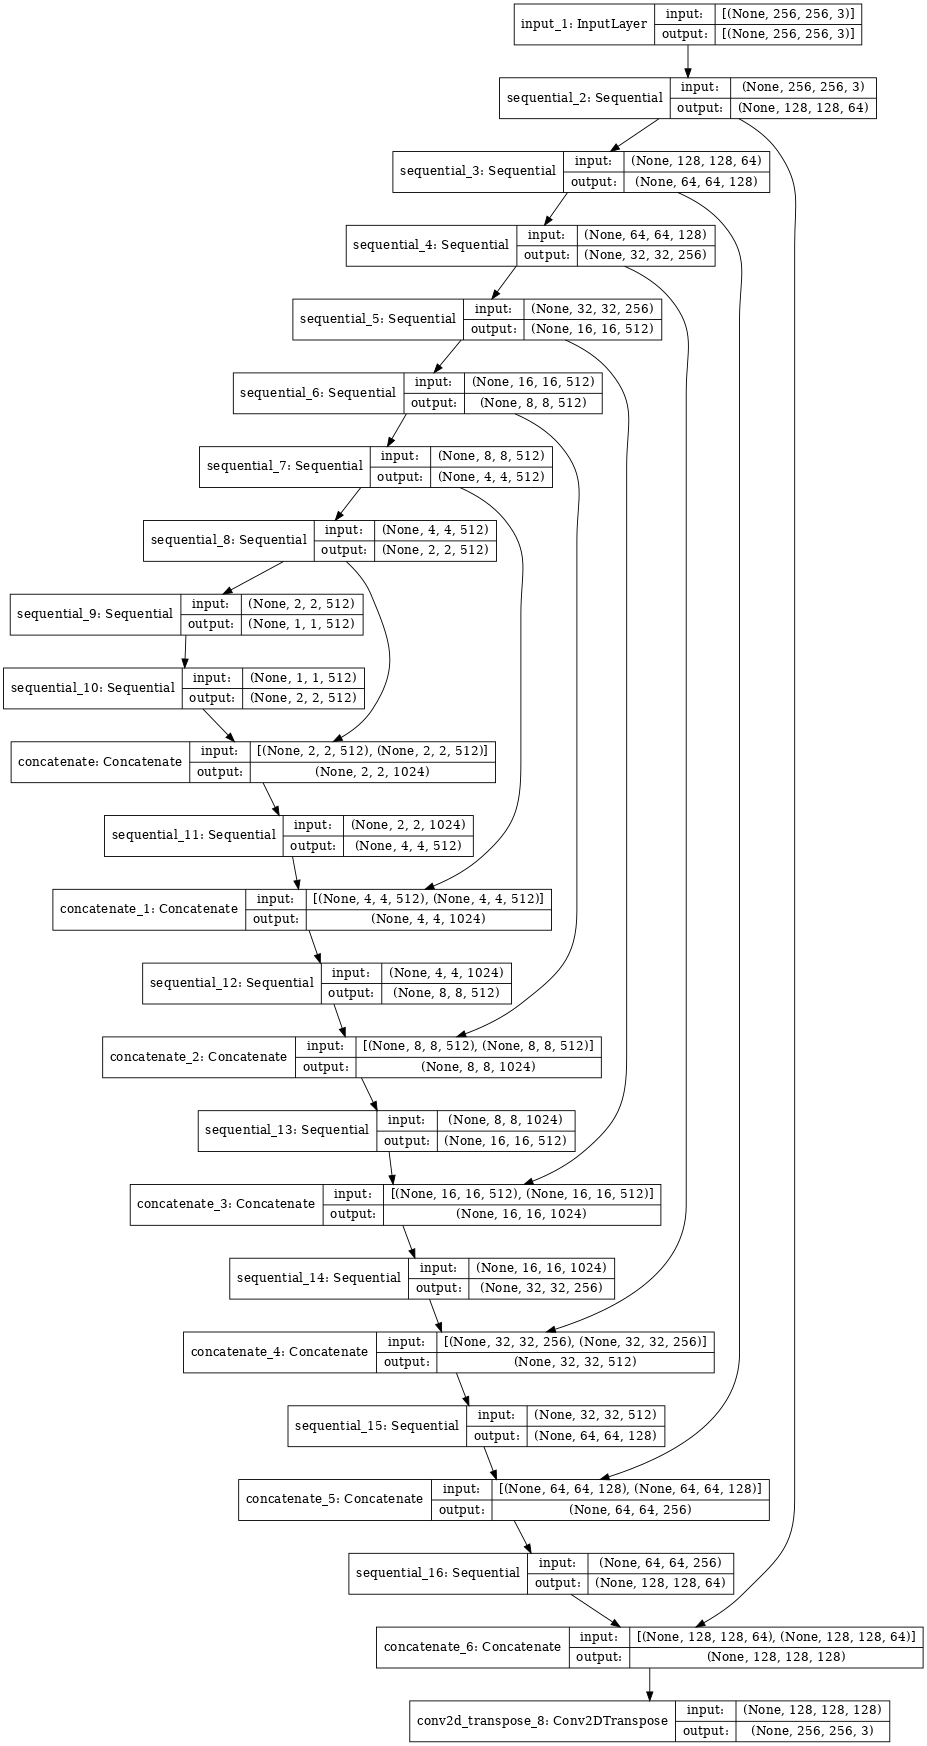

In [23]:
# 모델 생성 및 다이어그램 표현
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


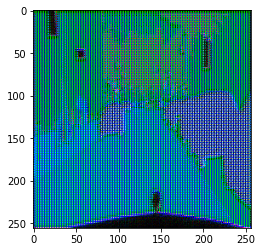

In [24]:
# 생성기 테스트를 위해 결과물 간단하게 출력
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### 생성자 손실 함수 구현

손실 함수는 시그모이드 교차 엔트로피 손실이며, 공식은 아래와 같습니다.
gan_loss + LAMBDA * l1_loss
LAMBDA는 하이퍼 파라미터이며, 저는 예시에 따라 100을 사용했습니다. 

또한 pix2pix에서는 L1 (MAE사용)도 언급이 있었다.

In [25]:
LAMBDA = 100

In [26]:
# 이진 교차 엔트로피
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error (MAE)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    # 위에서 언급한 두가지를 모두 사용함
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

### Disciminator (판별자 구축)

In [28]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

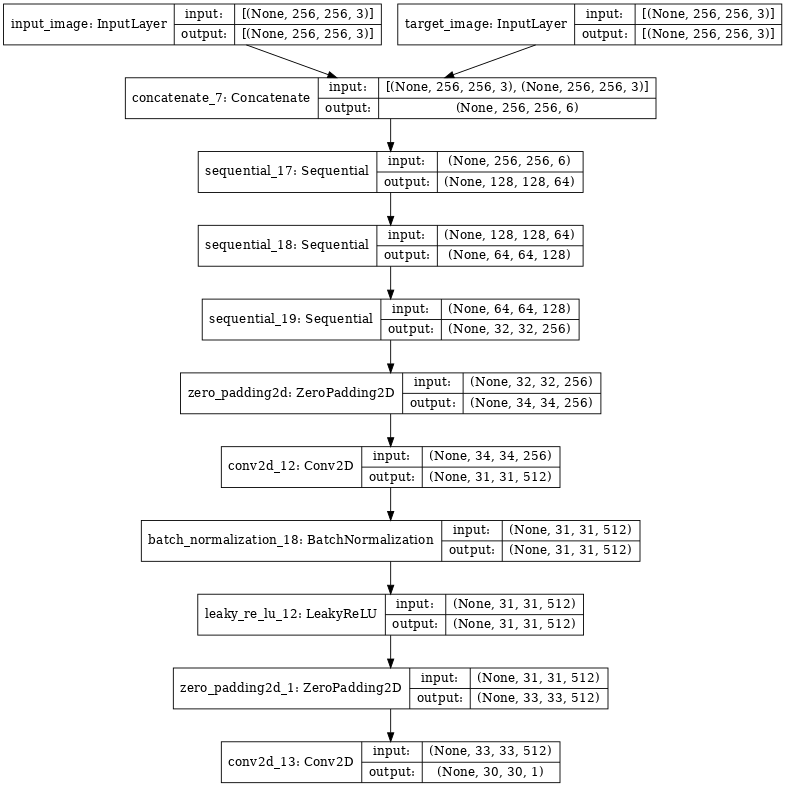

In [29]:
# 모델 시각화
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

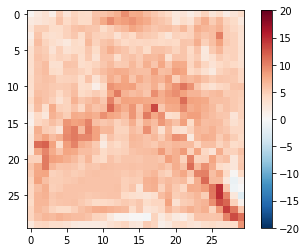

In [30]:
# 판별자 테스트
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### 판별자 손실 함수 구현

 진짜 이미지와 생성된 이미지의 두 입력
 
 시그모이드 교차 엔트로피 손실

In [31]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

### 옵티마이저 및 체크포인트 저장기 정의

In [32]:
# 아담이고 beta_1에 대한 하이퍼파라미터를 정의해줬다.
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [33]:
# 체크포인트 저장 함수 생성
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [34]:
# 이미지 생성 과정 함수 생성
# 학습 과정에서 일부 이미지를 출력하는데 이용한다.
def generate_images(model, test_input, tar):
    # 모델 예측
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    # 늘 보던 출력
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

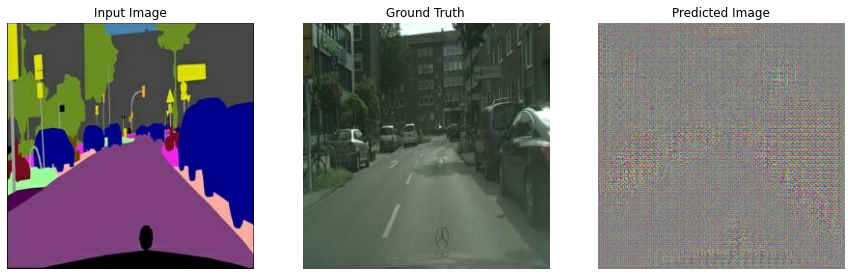

In [35]:
# 뽑아서 사용
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

### 학습 함수 구현

In [102]:
# 로거 정의
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [37]:
# 실질적인 학습 과정을 담고 있다.
@tf.function
def train_step(input_image, target, step):
    # 테이프 정의
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 생성기 생성
        gen_output = generator(input_image, training=True)
        
        # 실제 이미지 판별기 생성
        disc_real_output = discriminator([input_image, target], training=True)
        
        # 예측용 판별기 생성
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        # 손실 함수들 생성
        # 생성기 손실
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        # 판별기 손실
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    # 손실함수로 가중치 적용
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    # 손실함수로 판별기 가중치 적용
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
    
    # 최적화 진행
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    
    # 요약 생성
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [38]:
# 학습 함수
def fit(train_ds, test_ds, steps):
    # 이터레이터 생성
    example_input, example_target = next(iter(test_ds.take(1)))
    # 시작 시간
    start = time.time()

    # 이터레이터 루프
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        # 천회당 디스플레이 업데이트
        if (step) % 1000 == 0:
            display.clear_output(wait=True)
            
            # 로그 출력
            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()
            
            # 결과물 출력
            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")
        
        # 학습 1회 실행
        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every 5k steps
        # 오천번에 한번 체크포인트 저장
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

이미지가 1000개 이고 배치가 1이므로 40 epochs라고 볼 수 있다.

Time taken for 1000 steps: 93.14 sec



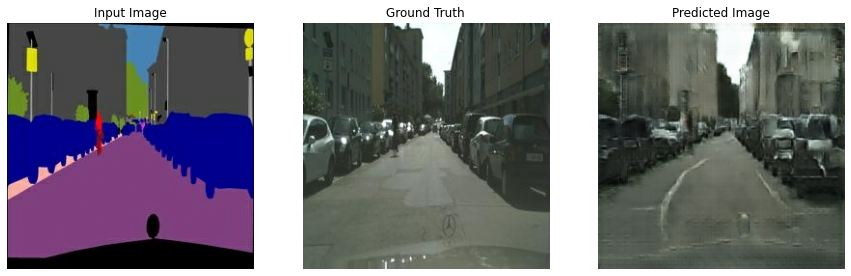

Step: 39k
....................................................................................................

In [39]:
# 학습 시작
fit(train_dataset, test_dataset, steps=40000)

In [111]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 741), started 0:00:20 ago. (Use '!kill 741' to kill it.)

In [110]:
%reload_ext tensorboard

In [106]:
!tensorboard dev upload --logdir {log_dir}


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) ^C
Traceback (most recent call last):
  File "/opt/conda/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/opt/conda/lib/python3.9/site-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/opt/conda/lib/python3.9/site-packages/absl/app.py", line 303, in run
    _run_main(main, args)
  File "/opt/conda/l

In [41]:
# 텐서보트 출력
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

Loss 값들이 점점 주는 경향을 볼 수 있다.

## 추론 확인

In [42]:
ls {checkpoint_dir}

checkpoint                  ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-5.index
ckpt-1.index                ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-2.index                ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-3.index                ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-4.index


In [43]:
# Restoring the latest checkpoint in checkpoint_dir
# 마지막 체크포인트 복원
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

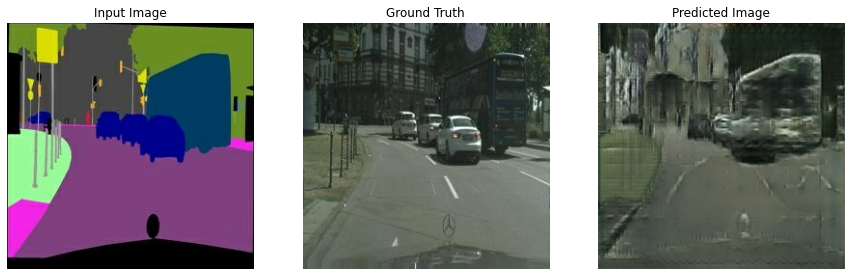

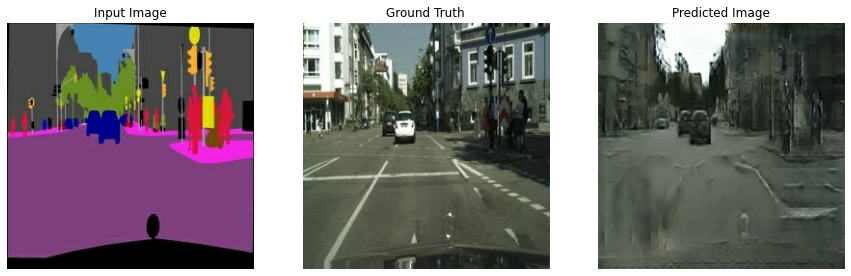

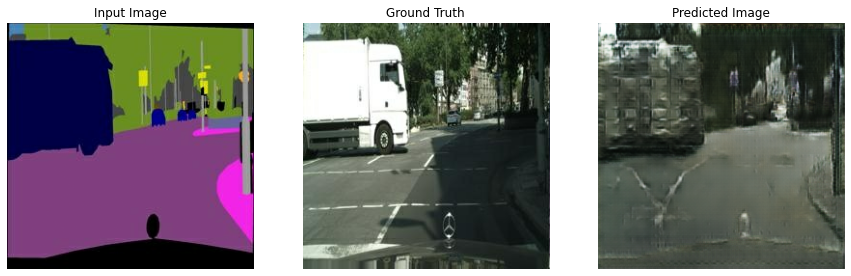

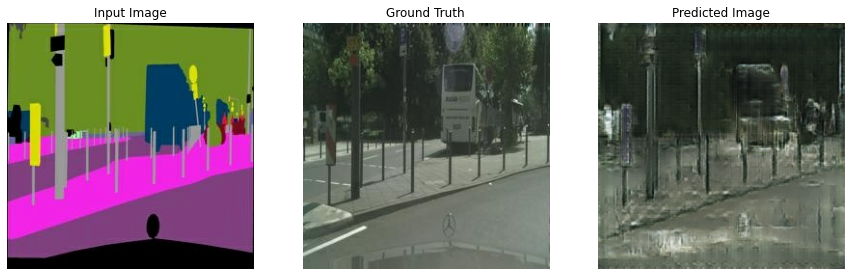

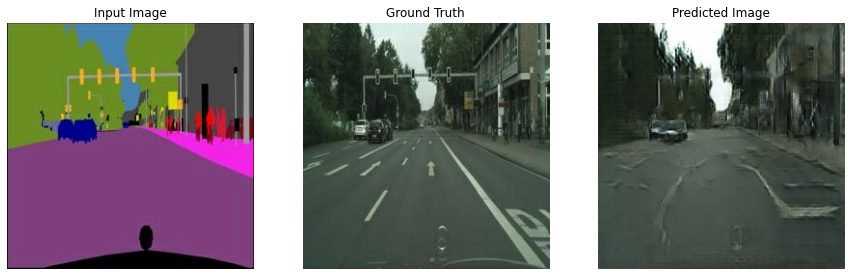

In [44]:
# Run the trained model on a few examples from the test set
# 테스트셋을 이용해서 추론
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)

아직 알아보기 쉽지 않지만, 충분히 괜찮은 결과를 보여줬다고 볼 수 있다.

## Subclassing API 사용해보기

평가 기준(루브릭)과 관련은 없지만,
위에서 이미 구현된 모델을 다른 방식으로 구현해보았다.

In [74]:
class DownSample(tf.keras.layers.Layer):
    def __init__(self, filters, size, apply_batchnorm=True):
        super(DownSample, self).__init__()
        self.apply_batchnorm = apply_batchnorm
        
        initializer = tf.random_normal_initializer(0., 0.02)
        
        # Layers
        self.conv = tf.keras.layers.Conv2D(
            filters, size, strides=2, padding='same',
            kernel_initializer=initializer, use_bias=False)
        
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.leaky_relu = tf.keras.layers.LeakyReLU()
    
    def call(self, x):
        x = self.conv(x)
        
        if self.apply_batchnorm:
            x = self.batchnorm(x)
        
        x = self.leaky_relu(x)
#         x = tf.squeeze(x, [1])
        
        return x

In [75]:
# 레이어 테스트
down_model = DownSample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(type(down_result))
print (down_result.shape)

# 이걸 써야 호환될듯
# down_result = tf.squeeze(down_result, [1])
print (down_result.shape)
# 예상: (1, 128, 128, 3)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 1, 128, 128, 3)
(1, 1, 128, 128, 3)


In [76]:
class DownSampleBlock(tf.keras.layers.Layer):
    def __init__(self):
        super(DownSampleBlock, self).__init__()
        filters = [64, 128, 256] + [512 for _ in range(5)]
        self.stack = []
        self.skips = []
        
        for f in filters:
            self.stack.append(DownSample(f, 4))
        
        self.stack[0].apply_batchnorm = False
        
    def call(self, x):
        for layer in self.stack:
            x = layer(x)
            self.skips.append(x)
        
        return x, self.skips

In [77]:
class UpSample(tf.keras.layers.Layer):
    def __init__(self, filters, size, apply_dropout=False):
        super(UpSample, self).__init__()
        self.apply_dropout = apply_dropout
        
        initializer = tf.random_normal_initializer(0., 0.02)
        
        # Layers
        self.transconv = tf.keras.layers.Conv2DTranspose(
            filters, size, strides=2, padding='same',
            kernel_initializer=initializer, use_bias=False)
        
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.relu = tf.keras.layers.ReLU()
    
    def call(self, x):
        x = self.transconv(x)
        x = self.batchnorm(x)
        
        if self.apply_dropout:
            x = self.dropout(x)
        
        x = self.relu(x)
        return x

In [78]:
class UpSampleBlock(tf.keras.layers.Layer):
    def __init__(self):
        super(UpSampleBlock, self).__init__()
        filters = [512 for _ in range(4)] + [256, 128, 64]
        self.stack = []
        
        for f in filters:
            self.stack.append(UpSample(f, 4))
        
        self.stack[0].apply_dropout = True
        self.stack[1].apply_dropout = True
        self.stack[2].apply_dropout = True
        
    def call(self, x, skips):
        for layer, skip in zip(self.stack, skips):
            x = layer(x)
            x = tf.keras.layers.Concatenate()([x, skip])
        
        return x

In [79]:
class Generator2(tf.keras.Model):
    def __init__(self):
        super(Generator2, self).__init__()
        self.down_stack = DownSampleBlock()
        self.up_stack = UpSampleBlock()
        
        initializer = tf.random_normal_initializer(0., 0.02)
        
        self.last_transconv = tf.keras.layers.Conv2DTranspose(
            OUTPUT_CHANNELS, 4, strides=2, padding='same',
            kernel_initializer=initializer, activation='tanh')
        
        self.skips = []
        
    def call(self, x):
        x, skips = self.down_stack(x)
        
        skips = reversed(skips[:-1])
        x = self.up_stack(x, skips)
        x = self.last_transconv(x)
        
        return x

In [80]:
class Discriminator2(tf.keras.Model):
    def __init__(self):
        super(Discriminator2, self).__init__()
        
        initializer = tf.random_normal_initializer(0., 0.02)
        
        self.down1 = DownSample(64, 4, False)
        self.down2 = DownSample(128, 4)
        self.down3 = DownSample(256, 4)
        
        self.zero_pad1 = tf.keras.layers.ZeroPadding2D()
        
        self.conv = tf.keras.layers.Conv2D(
            512, 4, strides=1, kernel_initializer=initializer, use_bias=False)
        
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.leaky_relu = tf.keras.layers.LeakyReLU()
        self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
        
        self.last_conv = tf.keras.layers.Conv2D(
            1, 4, strides=1, kernel_initializer=initializer)
        
    def call(self, inputs):
        inp, tar = inputs
        x = tf.keras.layers.concatenate([inp, tar])
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.batchnorm1(x)
        x = self.leaky_relu(x)
        x = self.zero_pad2(x)
        x = self.last_conv(x)
        return x

In [87]:
generator = Generator2()
discriminator = Discriminator2()

# 로거 정의
log_dir="logs2/"
summary_writer = tf.summary.create_file_writer(
  log_dir + "fit2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint_dir = './training_checkpoints2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [97]:
@tf.function
def train_step2(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image)
        disc_real_output = discriminator([input_image, target])
        
        disc_generated_output = discriminator([input_image, gen_output])
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    
#     with summary_writer.as_default():
#         tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
#         tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
#         tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
#         tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [100]:
# 학습 함수
def fit2(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()
    print('11')
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)
            print('11')
            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()
            print('11')
            generate_images(generator, example_input, example_target)
            print('11')
            print(f"Step: {step//1000}k")
        
        print('22')
        train_step2(input_image, target, step)

        if (step+1) % 10 == 0:
            print('.', end='', flush=True)

        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

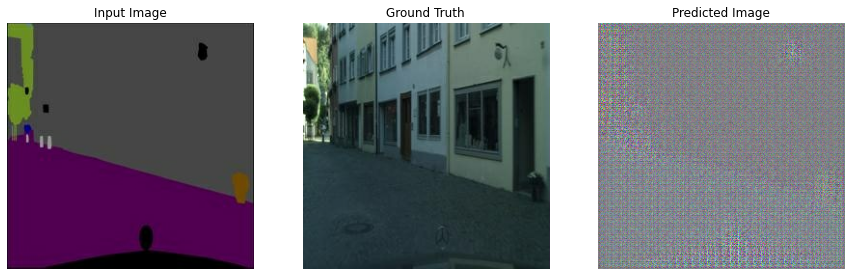

Step: 0k


NotFoundError:  Resource localhost/_AnonymousVar167/N10tensorflow22SummaryWriterInterfaceE does not exist.
	 [[node gen_total_loss/write_summary (defined at opt/conda/lib/python3.9/site-packages/tensorboard/plugins/scalar/summary_v2.py:93) ]] [Op:__inference_train_step_7706]

Errors may have originated from an input operation.
Input Source operations connected to node gen_total_loss/write_summary:
 floordiv (defined at tmp/ipykernel_436/4124064097.py:36)

Function call stack:
train_step


In [101]:
# 학습 시작
fit(train_dataset, test_dataset, steps=40000)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)

여러가지 방법을 시도했지만, 로컬에서 테스트한 결과 클라우드의 문제로 파악됬다.
서브클래스 구현은 아쉽지만 다음 모델에서 더 자세히 구현하고자한다.

![](https://github.com/crlotwhite-mirror/AiffelOnline4/blob/main/Exploration/Node7/result.jpg?raw=true)


큰 차이점이 있다면, Input 설정이 비교적 자유롭고, 중복 요소가 많은 업셈플 블록이나 다운샘플 블록 같은 것을 객체화하여 관리할 수 있다는 것이 너무 편했다.

케창딥에서는 객체지향 때문에 어렵다고 설명하지만, 객체지향에 경험도 있고 pytorch에 경험이 있는 나로서는 나름 편한 방법이었다고 생각이 들었다.